In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

from datetime import datetime, timedelta

from pykalman import KalmanFilter
from math import sqrt

# check how much of historical orderbook can be gotten
# entering into position slippage can be simulated here

In [2]:
# for now lets skip this for live iterating

# def run_adfuller_test(spread):
#     '''
#     run cointegration test if there are more than 100 observations
#     H0: that there is a unit root -> no stationarity
#     H1: there is no unit root -> stationary
#     pval > threshold value: cannot reject H0'''
#     if len(spread) >= 100:
#         '''settings for regression testing:
#         https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
#         here we assume no time trend in time series and no drift for simplicity!'''
#         return float(sm.tsa.adfuller(x=spread)[1])  # ,regression='ctt'
#     else:
#         return np.nan
      
# def run_johansen_test(data):
#     result = coint_johansen(data, det_order=0, k_ar_diff=1)
#     """r = 0 means no cointegration, r<=1 means up to one cointegration relationship etc
#     We have m hypothesised numbers of cointegrated equations: here at most 0, at most 1 
#     cvt - Critical values (90%, 95%, 99%) of trace statistic
#     lr1 - Trace statistic
#     Trace test:
#     H0: 0 cointegration equations
#     H1: coint. eq. exist > 0 
#     explanation https://www.youtube.com/watch?v=TB4m9M1sIJ0
#     """
#     stat_r0 = result.lr1[0]
#     crits_r0 = result.cvt[0]
#     # eig_stat_r0 = result.lr2[0]
#     # eig_crits_r0 = result.cvm[0]
#     stat_res = trace_results(stat_r0, crits_r0)  # there are 0 coint. equations. pass if rejected
#     # eig_res = trace_results(eig_stat_r0, eig_crits_r0)  # there are 0 coint. equations. pass if rejected
#     return stat_res

# def run_engel_granger(ts1, ts2):
#     '''H0: there is no cointegration
#     H1: there is cointegration relationship
#     pval < threshold value: reject H0
#     time series are assumed to be integrated of order 1!!!'''
#     return sm.tsa.coint(ts1, ts2, autolag='bic')[1]

In [3]:
from itertools import product

In [4]:
# print(np.arange(*(1, 10), 1))
# print(np.arange(*(90, 99), 1))
# print(np.arange(*(10, 800), 40))
combinations = list(product(np.arange(*(1, 10), 1), np.arange(*(90, 99), 1), np.arange(*(10, 550), 60)))
print(len(combinations)) # 726 ~ 12h on the currently used sample
# time optimization
# test windows on most reasonable entry exits (5/95, 4/96)
# then for best resulting window test
perc_comb = list(product(np.arange(*(2, 7), 1), np.arange(*(93, 98), 1)))
sltp_comb = list(product(np.arange(*(0.08, 0.13), 0.01), np.arange(*(0.01, 0.05), 0.01)))
print(len(perc_comb) * len(sltp_comb), len(np.arange(*(10, 800), 40))) # ~ 100/110 min
# sltp_comb
# for multiple pair optimization I should most probably create some cache, so process can be interrupted
# and restarted from the point of interruption

729
500 20


In [13]:
class IterativeBacktester:
  def __init__(
    self,
    pair,
    raw_data_dir,
    ticker_interval,
    save_dir="../processed_data/",
    perc_opt_range=None,
    tc=0.0006
    ):
    
    # global settings
    self.pair = pair
    self.save_dir = save_dir
    self.raw_data_dir = raw_data_dir
    self.ticker_interval = ticker_interval
    self.tc = tc
    
    # current backtest settings
    self.tp = None
    self.sl = None
    self.window = None
    self.iter_start = None
    self.z_short_perc = None
    self.z_long_perc = None
    self.param_str = None
    self.chart_spread = None
    
    # current optimization
    self.results = None
    
    # experimental feature to be implemented
    # so that every step we check certain range of percentiles
    # and take one with the highest profit results
    self.perc_opt_range = perc_opt_range
    
    #data
    self.tp_year = None
    self.data = None
    self.result = None
    self.opt_overview = None
    
    self._get_data()
    
  def __repr__(self):
      return "Pairs trading backtester"
        
  def _get_data(self):
    entries = []
    for instrument in self.pair:
      entries.append("%s_%s.csv" % (instrument, self.ticker_interval))
    # removing duplicates
    entries = list(set(entries))
      
    df_closings = pd.DataFrame()
    for entry in entries:
      instrument = "_".join(entry.split("_")[0:-1])
      df = pd.read_csv('%s/%s' % (self.raw_data_dir, entry), index_col="Date", parse_dates=["Date"])
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df["%s_returns" % instrument] = df[instrument]/df[instrument].shift(1)
      df_closings = pd.concat([df_closings, df], axis=1)
      
    df_closings.dropna(inplace=True)
    df_closings = df_closings.T.drop_duplicates().T
    self.data = df_closings
    self.tp_year = (self.data.shape[0] / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
    
    # wholesample for charting purposes
    state_means = KalmanFilterRegression(df_closings[self.pair[0]], df_closings[self.pair[1]])
      
    hr = - state_means[:, 0]
    spread = df_closings[self.pair[1]] + (df_closings[self.pair[0]]* hr)
    self.chart_spread = spread
    
  def optimize_pair(self, windows=[20, 60, 150, 300], long_entries_range=(2, 7, 1), short_entries_range=(93, 98, 1)):
    pass
  
  def get_Kalman_spread(self, series1, series2, avg_kalman=False):
    if avg_kalman is True:
      state_means = KalmanFilterRegression(KalmanFilterAverage(series1), KalmanFilterAverage(series2))
    else:
      state_means = KalmanFilterRegression(series1, series2)
          
    hedge_ratio = - state_means[:,0]
    spread = series1 + (series2 * hedge_ratio)
    
    return spread
      
  def backtest_pair(
    self,
    window=48,
    z_long_perc=5,
    z_short_perc=95,
    tp=0.01,
    sl=-0.01,
    avg_kalman=False,
    rolling_z_window=None,
    silent=False,
    start_date=None,
    use_pykalman=False
    ):
    
    self.tp = tp
    self.sl = sl
    self.window = window
    self.z_short_perc = z_short_perc
    self.z_long_perc = z_long_perc
    self.param_str = "w_{}_p_{}_{}_sltp_{}_{}".format(
      window, z_long_perc, z_short_perc, str(sl).replace(".", "d"), str(tp).replace(".", "d"))
    
    inst1 = self.pair[0]
    inst2 = self.pair[1]
    series1 = self.data[inst1].to_numpy()
    series2 = self.data[inst2].to_numpy()
    returns1 = self.data["%s_returns" % inst1].to_numpy()
    returns2 = self.data["%s_returns" % inst2].to_numpy()
    
    signals = np.empty((0, 1), dtype="float64")
    inst1_position = np.empty((0, 1), dtype="float64")
    inst2_position = np.empty((0, 1), dtype="float64")
    spread_record = np.empty((0, 1), dtype="float64")
    zscore = np.empty((0, 1), dtype="float64")
    z_long_record = np.empty((0, 1), dtype="float64")
    z_short_record = np.empty((0, 1), dtype="float64")
    gross_returns = np.empty((0, 1), dtype="float64")
    net_returns = np.empty((0, 1), dtype="float64")
    
    signal = 0
    old_signal = 0
    current_return = 0
    position1 = 0
    position2 = 0
    
    self.iter_start = window
    if start_date is not None: 
      try:
        self.iter_start = self.data.index.get_loc(start_date)
      except:
        print("Couldn't find start_date: %s" % start_date)
    
    # moving through the sample
    for t in range(self.iter_start, len(self.data)-1):
      # because of sampling index is off when sample[t]
      sample_series1 = series1[t-window:t+2]
      sample_series2 = series2[t-window:t+2]

      old_signal = signal
      old_position1 = position1
      old_position2 = position2
      gross = 0
      net = 0
      
      if use_pykalman:
        spread = self.get_Kalman_spread(sample_series1, sample_series2, avg_kalman=avg_kalman)
      else:
        mkf = MyKalmanFilter(delta=1e-4, R=2)
        spread = mkf.regression(sample_series1, sample_series2)
        
      if rolling_z_window:
        current_z_score, z_score_series = get_current_zscore(spread, rolling_window=rolling_z_window)
      else:
        z_score_series = (spread-spread.mean())/spread.std()
        current_z_score = z_score_series[-1]
      
      z_percentiles = np.percentile(z_score_series, [z_long_perc, z_short_perc])
      z_long = z_percentiles[0]
      z_short = z_percentiles[1]
      
      if old_signal == 0:
        if current_z_score < z_long: 
          signal = 1
        elif current_z_score > z_short: 
          signal = -1
      elif old_signal != 0:
        if current_return >= tp:
          signal = 0
        elif current_return <= sl:
          signal = 0
        
      position1 = -signal
      position2 = signal

      # check out what type of index is within the sample & if usage of "window+1" is legit
      gross = position1*returns1[t+1] + position2*returns2[t+1]
      net = gross - self.tc*(abs(position1 - old_position1) + abs(position2 - old_position2))
      if signal == old_signal:
        current_return = (1+current_return)*(1+net)-1
      else:
        current_return = net

      inst1_position = np.vstack((inst1_position, [position1]))
      inst2_position = np.vstack((inst2_position, [position2]))
      signals = np.vstack((signals, [signal]))
      spread_record = np.vstack((spread_record, [spread[-1]])) # double-check on this
      zscore = np.vstack((zscore, [current_z_score]))
      z_long_record = np.vstack((z_long_record, [z_long]))
      z_short_record = np.vstack((z_short_record, [z_short]))
      gross_returns = np.vstack((gross_returns, [gross]))
      net_returns = np.vstack((net_returns, [net]))
      

      # interface: reporting daily positions and realised returns
      if silent is True:
        continue
      
      # current stats
      print('\033[1m \033[37m', 100 * "=")
      if signal == 1:
        print('LONG: ',inst2,' SHORT: ',inst1, " z-score entry", z_long)
      elif signal == -1:
        print('LONG: ',inst1,' SHORT: ',inst2, " z-score entry", z_short)
      cum_net = round(np.prod(1+net_returns)*100-100, 2)
      print(
        "\033[0m", t, "/", series1.shape[0]-1,
        " \033%sCUM RET:" % get_pos_neg_color(cum_net), str(cum_net) + '% ',
        "\033%sCURENT NET:" % get_pos_neg_color(current_return), str(round(current_return, 3))+ '% ',
        "\033%sPOS:" % get_pos_neg_color(signal), signal
        )
      
    gross_cum = np.reshape(np.cumprod(1+gross_returns), (-1, 1))
    net_cum = np.reshape(np.cumprod(1+net_returns), (-1, 1))
    
    output = np.concatenate((
      inst1_position,
      inst2_position,
      signals,
      spread_record,
      zscore,
      z_long_record,
      z_short_record,
      gross_returns,
      net_returns,
      gross_cum,
      net_cum,
    ), axis=1)
    
    df = pd.DataFrame(output, columns=[
      "%s_position" % inst1, "%s_position" % inst2, "signals", "spread",
      "zscore", "z_long", "z_short", "gross_returns",
      "net_returns", "gross_cum", "net_cum"], index=self.data.index.copy()[self.iter_start+1:])
    
    self.result = df
    save_dir = None
    save_dir = self.save_dir
    self.get_backtest_charts(save_dir=save_dir, silent=silent)
    self.get_backtest_report(save_dir=save_dir, silent=silent)
    
    self._save_result_to_file()
    
    # TODO:
    # 1. Naming convention for save files/dirs. I.E. chart_w_400_p_3_97_sltp_28_3.png ✅
    # 2. Single pair optimization (sl/tp, window, percentiles)
      
  def get_backtest_report(self, save_dir=None, silent=False):
    # add winning positions amount & loosing positions amount
    ''' Calculates and prints various Performance Metrics.
    '''
    if save_dir is None and silent != False:
      return
    
    data = self.result.copy()
    strategy_net = round(data["net_cum"].iloc[-1], 2)
    strategy_gross = round(data["gross_cum"].iloc[-1], 2)
    max_dd, max_ddd, i = calculate_max_dd(data["net_cum"])
    ann_mean =          round(calculate_annualized_mean(self.tp_year, data["net_cum"]), 2)
    ann_std =           round(calculate_annualized_std(self.tp_year, data["net_cum"]), 2)
    sharpe = round(((data["net_cum"].mean() / data["net_cum"].std()) * sqrt(self.tp_year)), 2)
    
    entry_exit_idxs = self._get_positions()
    pos = []
    neg = []
    for idxs in entry_exit_idxs:
      pnl = data["net_cum"].loc[idxs[1]] - data["net_cum"].shift(1).loc[idxs[0]]
      if pnl < 0:
        neg.append(pnl)
      else:
        pos.append(pnl)
    
    if silent is False:
      print(100 * "=")
      print(
        "SPREAD TRADING | INSTRUMENTS = {}\nZ-PERCENTILES = {} | SL/TP = {} | WINDOW = {}".format(
          self.pair[0]+" & "+self.pair[1], [self.z_long_perc, self.z_short_perc], [self.sl, self.tp], self.window))
      print(100 * "-")
      print("PERFORMANCE MEASURES:")
      print("Net:         {}".format(strategy_net))
      print("Gross:       {}".format(strategy_gross))
      print(38 * "-")
      print("Annualized Mean:             {}".format(ann_mean))
      print("Annualized Std:              {}".format(ann_std))
      print("Sharpe Ratio:                {}".format(sharpe))
      print("Max Draw Down:               {}".format(round(max_dd, 2)))
      print("Max Draw Down Duration:      {}".format(max_ddd))
      print(38 * "-")
      print("{} winning positions w/ avg: {}".format(len(pos), round(np.mean(pos), 2)))
      print("{} loosing positions w/ avg: {}".format(len(neg), round(np.mean(neg), 2)))
      
      print(100 * "=")
    
    if save_dir is not None:
      f = open("%sreport_%s_%s.txt" % (save_dir, self.pair[0]+"_"+self.pair[1], self.param_str), "w")
      
      report = 100 * "=" + "\n"
      report += "SPREAD TRADING | INSTRUMENTS = {}\nZ-PERCENTILES = {} | SL/TP = {} | WINDOW = {}\n".format(
        self.pair[0]+" & "+self.pair[1], [self.z_long_perc, self.z_short_perc], [self.sl, self.tp], self.window)
      report += 100 * "-" + "\n"
      report += "PERFORMANCE MEASURES:\n"
      report += "Net:         {}\n".format(strategy_net)
      report += "Gross:       {}\n".format(strategy_gross)
      report += 38 * "-" + "\n"
      report += "Annualized Mean:             {}\n".format(ann_mean)
      report += "Annualized Std:              {}\n".format(ann_std)
      report += "Sharpe Ratio:                {}\n".format(sharpe)
      report += "Max Draw Down:               {}\n".format(round(max_dd, 2))
      report += "Max Draw Down Duration:      {}\n".format(max_ddd)
      report += 38 * "-" + "\n"
      report += "{} winning positions w/ avg: {}\n".format(len(pos), round(np.mean(pos), 2))
      report += "{} loosing positions w/ avg: {}\n".format(len(neg), round(np.mean(neg), 2))
      report += 100 * "="
      
      f.write(report)
      f.close()
      
  
  def get_backtest_charts(self, save_dir=None, silent=False):
    if save_dir is None and silent != False:
      return
    
    result = self.result.copy()
    fig, axs = plt.subplots(
      3, 1, gridspec_kw={'height_ratios': [2, 1, 2]}, 
      sharex=True, figsize=(18, 20))
    fig.patch.set_facecolor('lavender')
    fig.suptitle("PAIR: %s | INT: %s" % (self.pair[0]+"-"+self.pair[1], self.ticker_interval), fontsize=24)
    
    axs[0].plot(result["net_cum"], color="blue", label="NET")
    axs[0].plot(result["gross_cum"], color="orange", label="GROSS")
    axs[0].grid()
    axs[0].legend()
    axs[0].set_xlabel("PNL | NET: {}%".format(round((result.net_cum[-1] - 1)*100, 2)), fontsize=22)
    
    axs[1].plot(result["zscore"], color="black", label="ZSCORE")
    axs[1].plot(result["z_long"], color="green", label="ZLONG")
    axs[1].plot(result["z_short"], color="red", label="ZSHORT")
    axs[1].grid()
    axs[1].legend()
    axs[1].set_xlabel("ENTRIES", fontsize=22)
    
    spread = self.chart_spread.iloc[self.iter_start+1:].copy()
    long = spread.copy()
    short = spread.copy()
    long[result.signals!=1] = np.NaN
    short[result.signals!=-1] = np.NaN
    axs[2].plot(spread, color="slategrey", label="SPREAD")
    axs[2].plot(long, color="green", label="LONG")
    axs[2].plot(short, color="red", label="SHORT")
    axs[2].grid()
    axs[2].legend()
    axs[2].set_xlabel("POSITIONS", fontsize=22)
    
    if save_dir is not None:
      plt.savefig("%scharts_%s_%s.png"  % (save_dir, self.pair[0]+"-"+self.pair[1], self.param_str))
    
    # if silent != False:
    #   plt.show()
    
  
  def _save_result_to_file(self):
    self.result.to_csv("%sresult_%s_%s.csv" % (self.save_dir, self.pair[0]+"-"+self.pair[1], self.param_str))
  
  def _get_positions(self):
    ques = self.result.loc[
      ((self.result.signals == 0) & (self.result.signals.shift(1) != 0))
      | ((self.result.signals != 0) & (self.result.signals.shift(1) == 0))]
    grouped_idx = []
    for i, index in enumerate(ques.index):
      if i % 2 == 1:
        grouped_idx.append([index, ques.index[i+1]])
    
    # [[entry_timestamp, exit_timestamp], ...]
    return grouped_idx
    
      
# HELPERS
def get_pos_neg_color(number):
  if number > 0:
    return "[32m"
  elif number < 0:
    return "[31m"
  else:
    return "[0m"

def KalmanFilterAverage(x):
  # Construct a Kalman filter
  kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
  state_means, _ = kf.filter(x)
  # state_means = pd.Series(state_means.flatten())
  state_means = state_means.flatten()
  return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
  delta = 1e-3
  trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
  obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
  kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
  # Use the observations y to get running estimates and errors for the state parameters
  state_means, state_covs = kf.filter(y)
  return state_means

def half_life(spread):
  spread_lag = spread.shift(1)
  spread_lag.iloc[0] = spread_lag.iloc[1]
  spread_ret = spread - spread_lag
  spread_ret.iloc[0] = spread_ret.iloc[1]
  spread_lag2 = sm.add_constant(spread_lag)
  model = sm.OLS(spread_ret,spread_lag2)
  res = model.fit()
  halflife = int(round(-np.log(2) / res.params[1],0))
  if halflife <= 1:
      halflife = 1
  return halflife
  
def calculate_max_dd(cumret):
  # ======================================================
  # calculation of maximum drawdown and maximum drawdown duration based on
  # cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
  # i is the index of the day with maxDD.
  # ======================================================
  highwatermark=np.zeros(cumret.shape)
  drawdown=np.zeros(cumret.shape)
  drawdown_duration=np.zeros(cumret.shape)
  for t in np.arange(1, cumret.shape[0]):
      highwatermark[t]=np.maximum(highwatermark[t-1],
      cumret[t])
      drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
      if drawdown[t]==0:
          drawdown_duration[t]=0
      else:
          drawdown_duration[t]=drawdown_duration[t-1]+1
  max_dd, i = np.min(drawdown), np.argmin(drawdown) 
  # drawdown < 0 always
  max_ddd=np.max(drawdown_duration)
  return max_dd, max_ddd, i

def calculate_annualized_mean(tp_year, series):
        return series.mean() * tp_year
    
def calculate_annualized_std(tp_year, series):
    return series.std() * np.sqrt(tp_year)

def get_current_zscore(series, rolling_window=None):
  if rolling_window is not None:
    # this windows definitely could be optimized or sth
    spread_mean = series.rolling(center=False, window=rolling_window).mean()
    spread_std = series.rolling(center=False, window=rolling_window).std()
    z_score_series = (series-spread_mean)/spread_std
  else:  
    z_score_series = (series-series.mean())/series.std()
    
  return z_score_series.iloc[-1], z_score_series

class MyKalmanFilter:
    
  def __init__(self, delta=1e-4, R=1e-3):
    # measurement noise variance
    self.R = R

    # co-variance of process noise(2 dimensions)
    self.Q = delta / (1-delta) * np.eye(2)

    # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
    self.x = np.zeros((2, 1))     

    # state covariance
    self.P = np.ones((2,2))     

  def step_forward(self, y1, y2):
    # Before entering the equations, let's define H as (1, 2) matrix
    H = np.array([y2, 1])[None]
    # and define z
    z = y1

    ## TIME UPDATE ##
    # first thing is to predict new state as the previous one (2x1)
    x_hat = self.x[:, -1][..., None]

    # then, the uncertainty or covariance prediction 
    P_hat = self.P + self.Q

    ## MEASUREMENT UPDATE ##
    # calc the Kalman gain
    K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

    # state update part 1 (measurement estimation)
    z_hat = H.dot(x_hat)
    # state update part 2
    x = x_hat + K.dot(z-z_hat)

    # uncertainty update
    self.P = (np.eye(2)-K.dot(H)).dot(P_hat)

    # append the new state to the vector
    self.x = np.concatenate([self.x, x], axis=1)

    return x
  
  def regression(self, series1, series2):
    state_means = np.zeros((0, 2), dtype="float64")
    
    for t in range(0, series1.shape[0]):
        x = self.step_forward(series1[t], series2[t])
        state_means = np.vstack((state_means, [x[0][0], x[1][0]]))
    
    hedge_ratio = - state_means[:,0]
    spread = series1 + (series2 * hedge_ratio)
    
    return spread
  
def get_Kalman_spread(series1, series2, avg_kalman=False, vanilla=False):
  if avg_kalman is True:
    state_means = KalmanFilterRegression(KalmanFilterAverage(series1), KalmanFilterAverage(series2))
  if vanilla is True:
    mkf = MyKalmanFilter(delta=1e-4, R=2)
    spread = mkf.regression(series1, series2)
    return spread
  else:
    state_means = KalmanFilterRegression(series1, series2)
        
  hedge_ratio = - state_means[:,0]
  spread = series1 + (series2 * hedge_ratio)
  
  return spread

In [14]:
import warnings
warnings.filterwarnings('ignore')

backtester = IterativeBacktester(pair=["AUDIOUSDT_FUTURES", "FTMUSDT_FUTURES"], ticker_interval="15m", raw_data_dir="../raw_data/Binance_Historical_15m_FUTURES_20_days_2022-07-14T12:00:43", tc=0.0006)

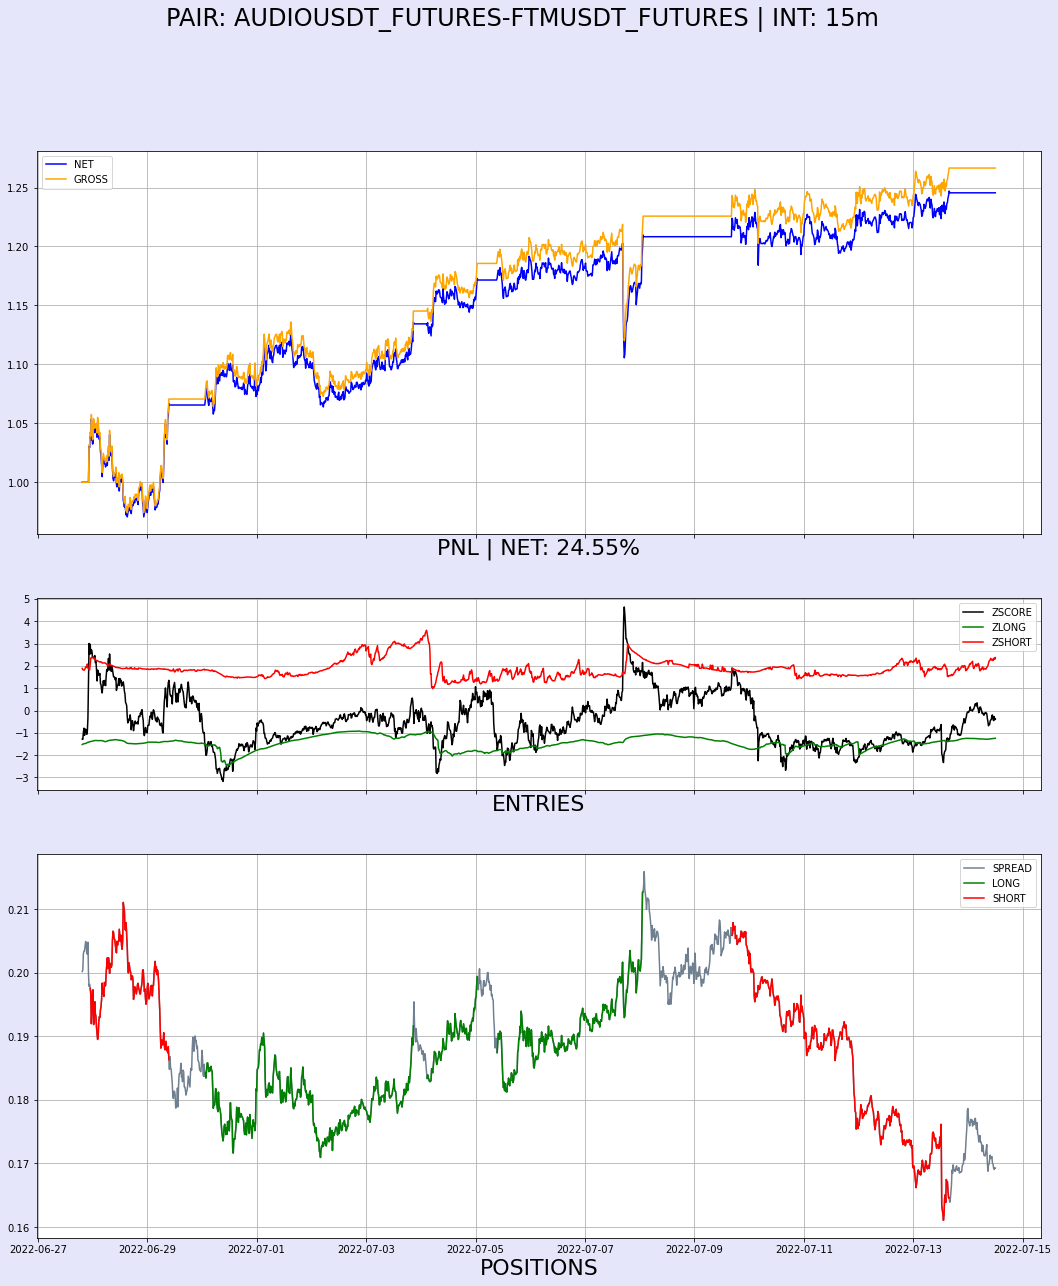

In [16]:


backtester.backtest_pair(start_date="2022-06-27 19:15:00",
  z_long_perc=3, z_short_perc=97, window=300,
  tp=0.03, sl=-0.12, use_pykalman=False, avg_kalman=False, silent=True)

In [ ]:
# WRONG IMPLEMENTATION 
# LEARN MATH!
class MyKalmanFilter_1D:
    
  def __init__(self, delta=1e-4, R=1e-3):
    # measurement noise variance
    self.R = R

    # co-variance of process noise(2 dimensions)
    self.Q = np.array([0.01]) #delta / (1-delta) * np.eye(2)

    # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
    self.x = np.array([0]) #np.zeros((2, 1))

    # state covariance
    self.P = np.array([1]) #np.ones((2,2))

  def step_forward(self, y1):
    # Before entering the equations, let's define H as (1, 2) matrix
    # H = np.array([y1, 1])[None]
    H = np.array([y1])
    # and define z
    # z = y1

    ## TIME UPDATE ##
    # first thing is to predict new state as the previous one (2x1)
    x_hat = self.x[-1][..., None]

    # then, the uncertainty or covariance prediction 
    P_hat = self.P + self.Q

    ## MEASUREMENT UPDATE ##
    # calc the Kalman gain
    K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

    # state update part 1 (measurement estimation)
    z_hat = H.dot(x_hat)
    # state update part 2
    # x = x_hat + K.dot(z-z_hat)
    x = x_hat + K.dot(H-z_hat)

    # uncertainty update
    self.P = (np.array([1])-K.dot(H)).dot(P_hat)

    # append the new state to the vector
    self.x = np.concatenate([self.x, x])

    return x
  
  def smoothing(self, series):
    state_means = np.zeros((0, 2), dtype="float64")
    
    for t in range(0, series.shape[0]):
        x = self.step_forward(series[t])
        print(x)
        # state_means = np.vstack((state_means, [x[0][0], x[1][0]]))
    
    
    return state_means
  
test_mkf_1D = MyKalmanFilter_1D(R=1)
series = np.array([1,2,3,10,2,1,
                   1,2,3,10,2,1,
                   1,2,3,10,2,1])
means_1D = test_mkf_1D.smoothing(series)



In [153]:
kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(series)
state_means = state_means.flatten()
state_means

array([0.5       , 1.00662252, 1.5209572 , 3.31317226, 3.07516338,
       2.74200892, 2.48820492, 2.42243362, 2.49545213, 3.39635121,
       3.23565755, 2.98710787, 2.77234376, 2.69077761, 2.7228218 ,
       3.4653436 , 3.31771439, 3.08662643])